In [ ]:
import requests
from dotenv import load_dotenv
import os
import pandas as pd
import steamspypi
import steamreviews
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



load_dotenv()
API_KEY = os.getenv("API_KEY")


# Collect the 100 most popular games on steam

In [ ]:
data_request = {"request": "top100owned"}
data = steamspypi.download(data_request)
df = pd.DataFrame(data.values())
df = df[['name', 'appid']]
display(df.head())


In [ ]:
def get_tags(appid):
    data_request = {"request": "appdetails", "appid": appid}
    data = steamspypi.download(data_request)
    return data['tags']

df['tags'] = df['appid'].apply(get_tags)

print(df)

# Construct player networks

Does it make sense to prune the friends of seed players based on wether they have the original game or not? The two options are smartly choosing the seed players or recursively looking at friends of friends who have the game until we have a big enough network.

In [ ]:
def get_friends_with_game(player_id, app_id):
    """ 
    Given a player_id and an app_id, returns a list of the player's friends who own the game.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    friends_with_game = []
    for friend in all_friends:
        games = []
        url = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={API_KEY}&steamid={friend}&format=json'
        response = requests.get(url)
        game_list = response.json()
        try:
            for item in game_list["response"]["games"]:
                games.append(item["appid"])
        except:
            continue
        if app_id in games:
            friends_with_game.append(friend)
    return friends_with_game
    
def get_friends(player_id):
    """ 
    Given a player_id, returns a list of the player's friends.
    """
    all_friends = []
    url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
    response = requests.get(url)
    friend_list = response.json()
    try:
        for item in friend_list["friendslist"]["friends"]:
            all_friends.append(item["steamid"])
    except:
        pass
        # print("Error getting friends.")
    return all_friends    
    
def get_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a list of players who own the game and their friends who own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends_with_game(player, app_id)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network

def get_non_ownership_network(app_id, params, seed_size=10, min_net_size=100):
    """ 
    Given an app_id, returns a friendship network of seed players. Friends of seeded players don't necessarily own the game.
    """
    # Get seed players
    review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    players = []
    for key in review_dict["reviews"].keys():
        if len(players) < seed_size:
            players.append(review_dict["reviews"][key]["author"]["steamid"])
    print("Seed players collected.")      
    network = players.copy()
    queue = players.copy()
    while queue:
        player = queue.pop(0)
        friends = get_friends(player)
        for friend in friends:
            if friend not in network:
                network.append(friend)
                queue.append(friend)
                # print(f"Added {friend} to the network.")
                if len(network) >= min_net_size:
                    return network
    return network

    
        
        
def get_edges(net_nodes):
    edges = []
    for node in net_nodes:
        friends = get_friends(node)
        for friend in friends:
            if friend in net_nodes:
                edges.append((node, friend))
    return edges

def construct_pajek_network(net_nodes, net_edges, app_id):
    with open(f"./Networks/{app_id}.net", "w") as f:
        f.write("*Vertices " + str(len(net_nodes)) + "\n")
        for i, node in enumerate(net_nodes):
            f.write(str(i+1) + ' "' + node + '"\n')
        f.write("*Edges\n")
        for edge in net_edges:
            f.write(str(net_nodes.index(edge[0]) + 1) + " " + str(net_nodes.index(edge[1]) + 1) + "\n")
    
def construct_network(app_id, params, seed_size=10, min_net_size=100):
    net_nodes = get_non_ownership_network(app_id, params, seed_size, min_net_size)
    print("Nodes collected.")
    net_edges = get_edges(net_nodes)
    print("Edges collected.")
    construct_pajek_network(net_nodes, net_edges, app_id)
    print("Network constructed.")

In [ ]:
request_params = dict()
request_params['language'] = 'english'
request_params['review_type'] = 'positive'
request_params['purchase_type'] = 'steam'
request_params['day_range'] = '30'

In [ ]:
files = os.listdir("./Networks")
files = [file.split(".")[0] for file in files]
for row in df.iterrows():
    app_id = row[1]['appid']
    if str(app_id) not in files:
        print(f"Constructing network for {row[1]['name']}.")
        construct_network(app_id, request_params, 10, 10000)
    else:
        print(f"Network for {row[1]['name']} already exists.")

# Network Structure

Compare the overall structure of the friendship networks, including metrics like density, average degree, and assortativity. Are there significant differences in how connected or clustered the networks are based on the games?

In [ ]:
import networkx as nx
import os

files = os.listdir("./Networks")
for file in files:
    id = file.split(".")[0]
    G = nx.read_pajek(f"./Networks/{file}")
    G = nx.Graph(G)
    if G.number_of_nodes() == 0:
        continue
    clustering_coefficient = nx.average_clustering(G)
    avg_degree = sum(dict(G.degree()).values()) / len(G)
    density = nx.density(G)
    largest_cc = max(nx.connected_components(G), key=len)
    df.loc[df['appid'] == int(id), 'avg_degree'] = avg_degree
    df.loc[df['appid'] == int(id), 'density'] = density
    df.loc[df['appid'] == int(id), 'clustering_coefficient'] = clustering_coefficient
    df.loc[df['appid'] == int(app_id), 'largest_connected_component'] = len(largest_cc)
    
df.to_csv("steam_data.csv")    


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['avg_degree'], df['density'], df['clustering_coefficient'])
ax.set_xlabel('Average Degree')
ax.set_ylabel('Density')
ax.set_zlabel('Clustering Coefficient')

plt.show()


# Centrality Measures

 Investigate the centrality of nodes (players) within each network. Are there players who act as hubs or connectors within their respective communities? Do certain games tend to have more centralized or decentralized networks?

In [ ]:
files = os.listdir("./Networks")
df = pd.read_csv("steam_data.csv")
for file in files:
    id = file.split(".")[0]
    G = nx.read_pajek(f"./Networks/{file}")
    G = nx.Graph(G)
    if G.number_of_nodes() == 0:
        continue
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    df.loc[df['appid'] == int(id), 'degree_centrality'] = np.mean(list(degree_centrality.values()))
    df.loc[df['appid'] == int(id), 'closeness_centrality'] = np.mean(list(closeness_centrality.values()))
    df.loc[df['appid'] == int(id), 'betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))
df.to_csv("steam_data.csv")

In [ ]:
df = pd.read_csv("steam_data.csv")

In [ ]:
fig, axs = plt.subplots(3, 1)
axs[0].hist(df['degree_centrality'], bins=72)
axs[0].set_title('Degree Centrality')
axs[1].hist(df['closeness_centrality'], bins=72)
axs[1].set_title('Closeness Centrality')
axs[2].hist(df['betweenness_centrality'], bins=72)
axs[2].set_title('Betweenness Centrality')
plt.tight_layout()
plt.show()

# Community Detection

Apply community detection algorithms to identify groups or communities within each network. Are there distinct community structures associated with different games? How do these communities overlap or interact?

# Clustering of networks

In [ ]:
df_std = df.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler
variables = ["avg_degree","density","clustering_coefficient","degree_centrality","closeness_centrality","betweenness_centrality"]
scaler = StandardScaler()

# standardize variables in the dataframe
df_std[variables] = scaler.fit_transform(df_std[variables])


In [ ]:
# Find any missing values in the dataframe
df_std.isnull().sum()
# Drop any rows with missing values
df_std = df_std.dropna()


In [ ]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=2)

# Fit the model to your standardized data
df_std['cluster'] = dbscan.fit_predict(df_std[variables])
df_std.describe()

In [ ]:
df_std_1 = df_std[df_std['cluster'] == 1]
df_std_0 = df_std[df_std['cluster'] == 0]
df_std_2 = df_std[df_std['cluster'] == 2]
df_std__1 = df_std[df_std['cluster'] == -1]

In [ ]:
for df in [df_std_0, df_std_1, df_std_2, df_std__1]:
    print(f"Cluster {df['cluster'].iloc[0]} has length of {len(df)}")

In [ ]:
from collections import Counter

# Initialize a Counter to keep track of key frequencies
key_counter = Counter()

# Iterate through each row in the 'tags' column and update the counter with the keys
for tags_dict in df_std__1['tags']:
    # Convert the string to a dictionary
    tags_dict = eval(tags_dict)
    key_counter.update(tags_dict.keys())

top_5_keys = key_counter.most_common(5)

# Prepare a list to store the results
top_5_results = []

# Count the number of rows that contain each of the top 5 keys
for key, count in top_5_keys:
    rows_with_key = sum(key in tags_dict for tags_dict in df['tags'])
    top_5_results.append((key, rows_with_key))

# Print the results
for key, rows_with_key in top_5_results:
    print(f"The key '{key}' appears in {rows_with_key} rows.")


# New ownership approach

In [ ]:
import requests
import time
from collections import deque
import json

#API_KEY = 'YOUR_API_KEY'  # Replace with your actual API key

def get_friends_with_game(player_id, app_id):
    """ 
    Given a player_id and an app_id, returns a list of the player's friends who own the game.
    """
    friends_with_game = []
    try:
        # Fetch the friend list of the player
        url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
        response = requests.get(url)
        friend_list = response.json().get('friendslist', {}).get('friends', [])
        print(f"Found {len(friend_list)} friends for player {player_id}.")
        
        for friend in friend_list:
            friend_id = friend['steamid']
            # Check if the friend owns the game
            # url = f'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={API_KEY}&steamid={friend_id}&format=json'
            url = f'http://api.steampowered.com/ISteamUserStats/GetUserStatsForGame/v0002/?appid={app_id}&key={API_KEY}&steamid={friend_id}'
            response = requests.get(url)
            if len(response.json()) > 0:
                friends_with_game.append(friend_id)
            # games = response.json().get('response', {}).get('games', [])
            # print(games)
            # 
            # if any(game['appid'] == app_id for game in games):
            #     friends_with_game.append(friend_id)
        
        time.sleep(1)  # Add delay to avoid hitting rate limits
    except requests.RequestException as e:
        print(f"Request failed: {e}")
    except KeyError as e:
        print(f"Unexpected data format: {e}")
    return friends_with_game

def save_network_to_file(network, file_path):
    """ 
    Save the current network to a file.
    """
    with open(file_path, 'w') as file:
        json.dump(list(network), file)

def get_ownership_network(app_id, params, seed_size=10, max_depth=3):
    """ 
    Given an app_id, returns a list of players who own the game and their friends who own the game.
    """
    # Get seed players from reviews
    # review_dict, query_count = steamreviews.download_reviews_for_app_id(app_id, chosen_request_params=params)
    # seed_players = [review_dict["reviews"][key]["author"]["steamid"] for key in review_dict["reviews"].keys()][:seed_size]
    seed_players = [76561198884121016, 76561198217410319, 76561198144493390, 76561198201921879, 76561198048626572]
    # seed_players = [76561198017205597]
    network = set(seed_players)
    queue = deque((seed_player, 0) for seed_player in seed_players)  # Queue of (player, depth) tuples

    while queue:
        player, depth = queue.popleft()
        
        if depth < max_depth:
            friends = get_friends_with_game(player, app_id)
        
            for friend in friends:
                if friend not in network:
                    network.add(friend)
                    print(f"Current size of newtorks = {len(network)}")
                    queue.append((friend, depth + 1))
                    if len(network) % 100 == 0:
                        save_network_to_file(network, f"./{app_id}_network.json")
                        print(f"Saved network data with {len(network)} nodes")
    
    return list(network)

# Example usage:
# params = { ... }  # Define your review query parameters
# app_id = YOUR_APP_ID  # Replace with the specific game app ID
# network = get_ownership_network(app_id, params, seed_size=10, max_depth=3)
# print(network)


In [ ]:
def get_edges(net_nodes):
    edges = []
    for node in net_nodes:
        friends = get_friends(node)
        for friend in friends:
            if friend in net_nodes:
                edges.append((node, friend))
    return edges

def construct_pajek_network(net_nodes, net_edges, app_id):
    with open(f".INA_Project\Networks\{app_id}.net", "w") as f:
        f.write("*Vertices " + str(len(net_nodes)) + "\n")
        for i, node in enumerate(net_nodes):
            f.write(str(i+1) + ' "' + str(node) + '"\n')
        f.write("*Edges\n")
        for edge in net_edges:
            f.write(str(net_nodes.index(edge[0]) + 1) + " " + str(net_nodes.index(edge[1]) + 1) + "\n")
    
def construct_network(app_id, params, seed_size=10, min_net_size=100):
    net_nodes = get_non_ownership_network(app_id, params, seed_size, min_net_size)
    print("Nodes collected.")
    net_edges = get_edges(net_nodes)
    print("Edges collected.")
    construct_pajek_network(net_nodes, net_edges, app_id)
    print("Network constructed.")

In [ ]:
request_params = dict()
request_params['language'] = 'english'
request_params['review_type'] = 'positive'
request_params['purchase_type'] = 'steam'
request_params['day_range'] = '30'

In [ ]:
[76561198884121016, 76561198217410319, 76561198144493390, 76561198201921879, 76561198048626572]
url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid={player_id}&relationship=friend'
response = requests.get(url)
friend_list = response.json().get('friendslist', {}).get('friends', [])
print(f"Found {len(friend_list)} friends for player {player_id}.")

In [ ]:
import tqdm as tqdm

In [ ]:
def get_edges(net_nodes):
    net_nodes = set(net_nodes)  # convert list to set for faster lookup
    edges = []
    save_interval = 200  # define the interval at which you want to save the edges

    # Load processed nodes if exists
    try:
        with open('processed_nodes.txt', 'r') as f:
            processed_nodes = set(line.strip() for line in f)
    except FileNotFoundError:
        processed_nodes = set()

    for i, node in enumerate(tqdm(net_nodes)):
        if node in processed_nodes:
            continue

        friends = get_friends(node)
        for friend in friends:
            if friend in net_nodes:
                edges.append((node, friend))

        processed_nodes.add(node)

        # Save edges and processed nodes periodically
        if i % save_interval == 0:
            with open('edges.txt', 'a') as f:
                for edge in edges:
                    f.write(f'{edge[0]} {edge[1]}\n')
            with open('processed_nodes.txt', 'w') as f:
                for processed_node in processed_nodes:
                    f.write(f'{processed_node}\n')
            edges = []  # clear the edges list after saving

    # Save remaining edges and processed nodes
    if edges:
        with open('edges.txt', 'a') as f:
            for edge in edges:
                f.write(f'{edge[0]} {edge[1]}\n')
    if processed_nodes:
        with open('processed_nodes.txt', 'w') as f:
            for processed_node in processed_nodes:
                f.write(f'{processed_node}\n')

    return edges

In [ ]:
friends = get_ownership_network(730, request_params, 10, 3)

In [ ]:
# recrete friends variable from the saved file
with open("730_network.json", 'r') as file:
    friends = json.load(file)

In [ ]:
len(friends)

In [ ]:
edges = get_edges(friends)

In [62]:
def construct_pajek_network(net_nodes, net_edges, app_id):

    with open(f"./Networks/{app_id}.net", "w") as f:
        f.write("*Vertices " + str(len(net_nodes)) + "\n")
        for i, node in enumerate(net_nodes):
            f.write(str(i+1) + ' "' + str(node) + '"\n')
        f.write("*Edges\n")
        for edge in net_edges:
            if edge[0] in net_nodes and edge[1] in net_nodes:
                f.write(str(net_nodes.index(str(edge[0])) + 1) + " " + str(net_nodes.index(str(edge[1])) + 1) + "\n")
            else:
                print(f"Edge {edge} not in nodes.")

In [55]:
len(edges)

700238

In [48]:
edges = []

with open('edges.txt', 'r') as f:
    for line in f:
        node1, node2 = line.strip().split()
        edges.append((node1, node2))

print(len(edges))

700238


In [63]:
construct_pajek_network(friends, edges, 730)

In [ ]:
url = f'http://api.steampowered.com/ISteamUser/GetFriendList/v0001/?key={API_KEY}&steamid=76561198048626572&relationship=friend'
response = requests.get(url)
print(response) 


In [83]:

G = nx.read_pajek(f"Networks/730.net")
G = nx.Graph(G)

In [87]:
#check number of nodes and edges
print(G.number_of_nodes())
print(G.number_of_edges())

44398
383756


In [86]:
def VisualizeNetwork(G, title):
    plt.figure(figsize=(12,12))
    nx.draw(G, node_size=20, with_labels=False)
    plt.title(title)
    plt.savefig(title + ".pdf")
    plt.show()


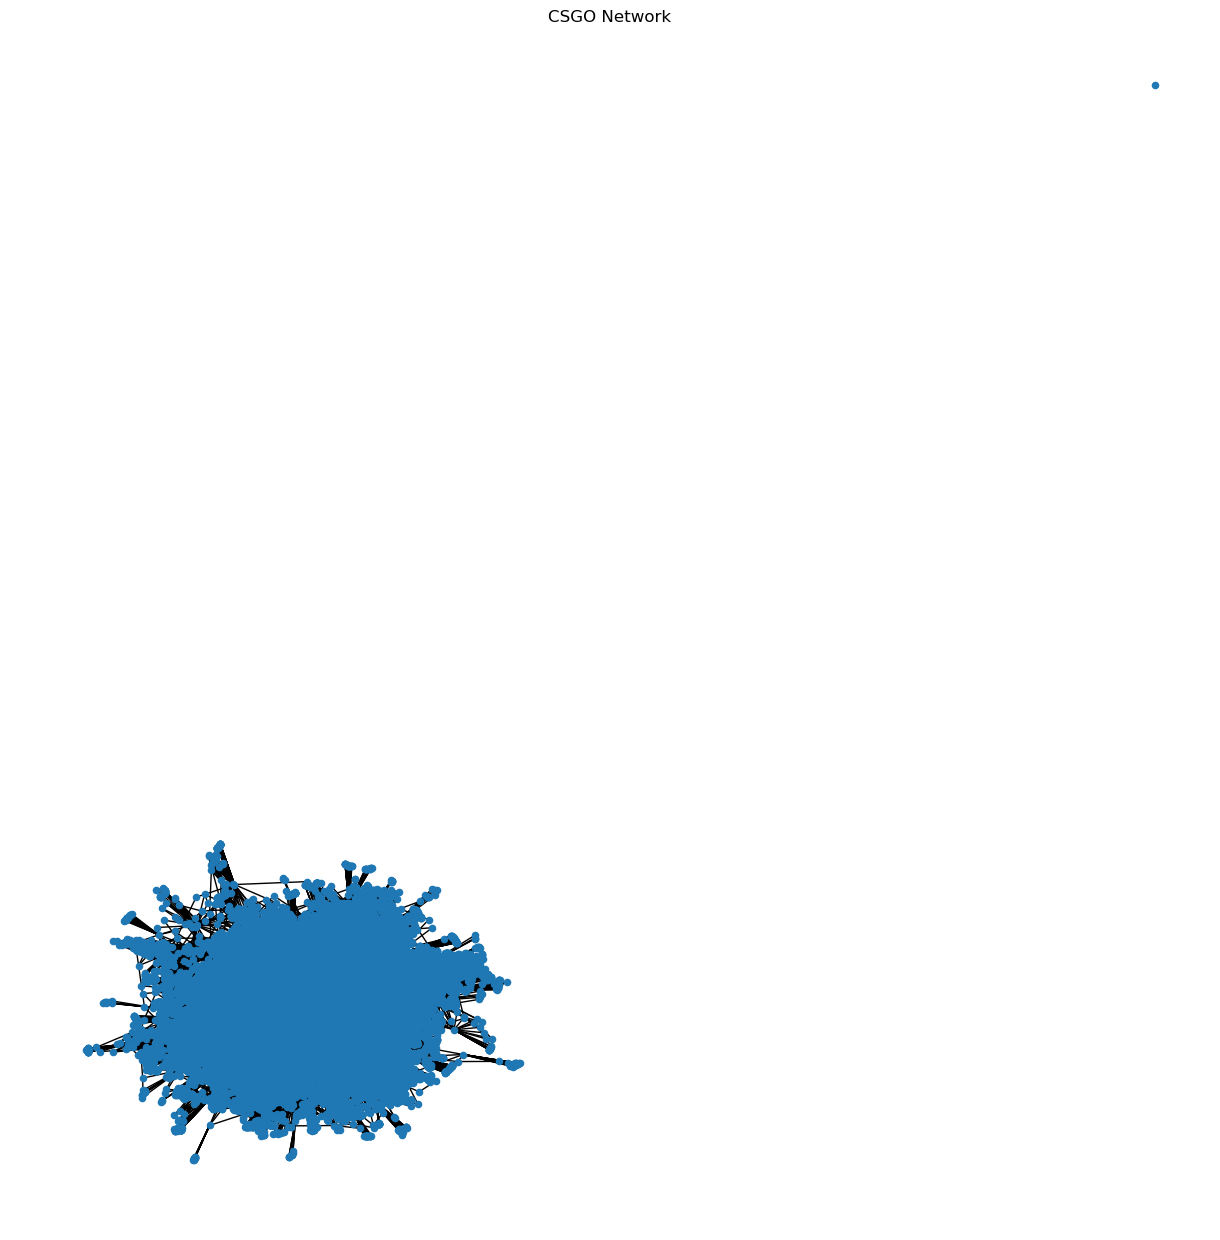

In [88]:
VisualizeNetwork(G, "CSGO Network")

In [76]:
from cdlib import algorithms, viz, evaluation
import networkx as nx

In [77]:

coms = algorithms.louvain(G, weight='weight', resolution=1.)
mod = coms.newman_girvan_modularity()

In [78]:
print(len(coms.communities))

37


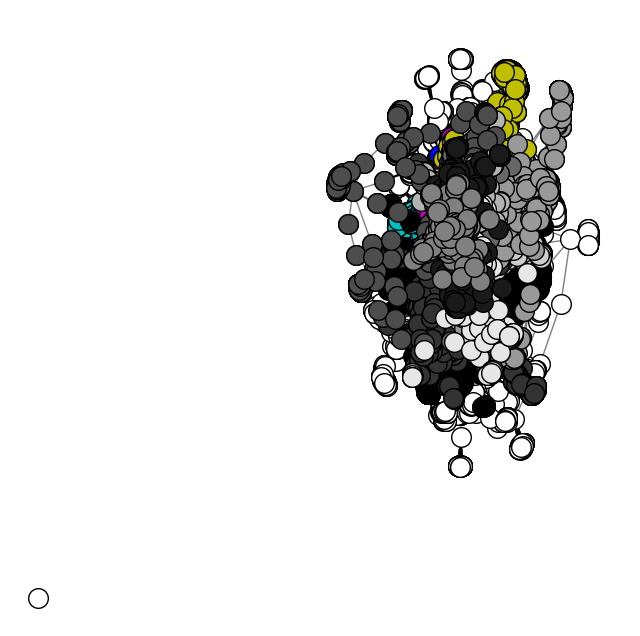

In [81]:
viz.plot_network_clusters(G, coms, pos)
plt.savefig('network_clusters_570.pdf')

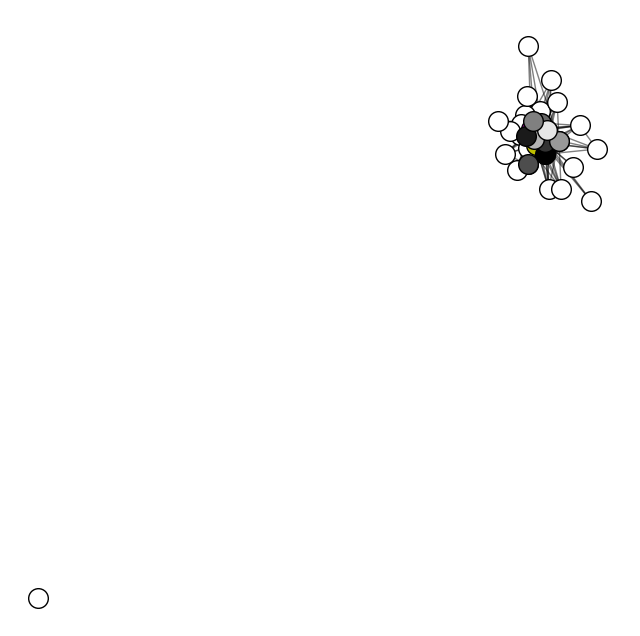

In [82]:
viz.plot_community_graph(G, coms)
plt.savefig('community_graph_570.pdf')